# Example plots

This notebook reproduces the trail/plume tracking plots found in the text.
It requires a data directory that contains the following:

- `meander_agent.zip`: saved trail tracking model
- `plume_agent.zip`: saved plume tracking model
- `trail_runs/`: directory containing benchmarking runs from the `meander_bench.py` script
- `plume_runs/`: directory containing benchmarking runs from the `plume_bench.py` script

These files are produced by their respective benchmarking scripts.

In [1]:
from pathlib import Path
import shutil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from stable_baselines3 import PPO
from tqdm import tqdm

sys.path.append('../')
from env import *
from curriculum import *


"""Ensure all data files are located here"""
data_dir = Path('data/')


def load_runs(run_dir):
    run_dir = Path(run_dir)
    df = None
    for result_pkl in run_dir.iterdir():
        if type(df) == type(None):
            df = pd.read_pickle(result_pkl)
        else:
            tmp_df = pd.read_pickle(result_pkl)
            df = pd.concat((df ,tmp_df))

    def extract_plot_vals(row):
        traj_lens = [len(traj) for traj in row['runs']]
        assert len(traj_lens) == 1

        return pd.Series([
            row['name'],
            traj_lens[0]
        ], index=['name', 'traj_len'])

    plot_df = df.apply(extract_plot_vals, axis=1)
    return df, plot_df


def plot_trajectory(traj, title='Trajectory', save_path=None):
    plt.gcf().set_size_inches(4, 2.5)
    ax = plt.gca()
    traj_lens, traj_probs = zip(*traj)
    ax.plot(traj_lens, 'r-', label='Trajectory')
    ax2 = ax.twinx()
    ax2.plot(traj_probs, 'k--', label='Success rate', alpha=0.8)

    ax.tick_params(labelsize=18)
    ax.tick_params(axis='y', labelcolor='red', color='red')
    ax2.tick_params(labelsize=18)
    ax.set_xlabel('Steps', fontsize=20)
    ax.set_ylabel('Difficulty (k)', fontsize=20, color='red')
    ax2.set_ylabel('Success rate', fontsize=20)
    ax2.set_ylim(bottom=-0.05)
    ax.set_title(title, fontsize=22)

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.bottom.set_linewidth(1.25)
    ax.spines.left.set_linewidth(1.25)
    ax.spines.left.set_color('red')

    ax2.spines.top.set_visible(False)
    ax2.spines.right.set_linewidth(1.25)
    ax2.spines.bottom.set_linewidth(1.25)
    ax2.spines.left.set_visible(False)

    plt.gcf().tight_layout()
    if save_path is not None:
        plt.savefig(save_path)


def plot_benchmark(plot_df, title='Benchmarks', save_path=None):
    fig, axs = plt.subplots(1, 1, figsize=(4, 2.5))
    axs = [axs]

    ax = sns.violinplot(plot_df, x='name', y='traj_len', hue='name', palette=['C1', 'C2', 'C3'], ax=axs[0], fill=False, inner='point', width=0.75)
    ax.set_ylabel('Steps', fontsize=20)
    ax.set_xlabel('')

    x_labs = ['ADP', 'INC', 'RAND']
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(x_labs, fontsize=18)
    ax.tick_params(labelsize=16)
    ax.set_title(title, fontsize=22)

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.bottom.set_linewidth(1.25)
    ax.spines.top.set_linewidth(1.25)

    fig.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)


def run_model(model_path, trail_map):
    model = PPO.load(model_path, device='cpu', custom_objects={'lr_schedule': 0, 'clip_range': 0})
    env = TrailEnv(trail_map, discrete=True, treadmill=True)

    obs = env.reset()
    all_obs = [obs]
    while True:
        action, _ = model.predict(obs, deterministic=True)
        obs, _, is_done, _ = env.step(action)

        all_obs.append(obs)

        if is_done:
            break

    return np.array(env.agent.position_history), {'agent': env.agent, 'obs': all_obs}


def plot_run(trail_map, pos_hist, save_path=None, ax=None, **plot_kwargs):
    if ax is None:
        ax = plt.gca()

    trail_map.plot(ax=ax, **plot_kwargs)
    ax.plot(pos_hist[:,0], pos_hist[:,1], linewidth=1.5, color='black')

    plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path)


def plot_observations(i, obs, fig_path):
    obs_dir = fig_path / f'example_{i}_obs'
    if obs_dir.exists():
        shutil.rmtree(obs_dir)
    
    obs_dir.mkdir()
    for i, obs in enumerate(obs):
        plt.clf()
        plt.gca().set_axis_off()
        plt.imshow(obs / (np.max(obs, axis=(0, 1)) + 1e-8), interpolation='nearest')
        plt.savefig(obs_dir / f'obs_{i}.svg')


# Benchmark plots

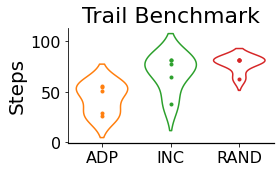

In [2]:
df, plot_df = load_runs(data_dir / 'trail_runs')
plot_benchmark(plot_df, title='Trail Benchmark', save_path='fig/meander_bench.svg')
plt.show()


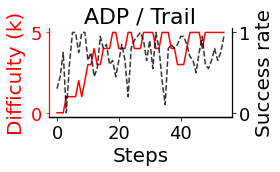

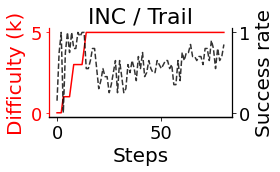

In [3]:
traj = df['runs'].iloc[0][0]
plot_trajectory(traj, title='ADP / Trail', save_path='fig/adp_trail_traj.svg')
plt.gcf().tight_layout()
plt.show()


traj = df['runs'].iloc[1][0]
plot_trajectory(traj, title='INC / Trail', save_path='fig/inc_trail_traj.svg')
plt.gcf().tight_layout()
plt.show()

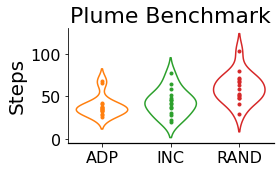

In [4]:
df, plot_df = load_runs(data_dir / 'plume_runs')
plot_benchmark(plot_df, title='Plume Benchmark', save_path='fig/plume_bench.svg')

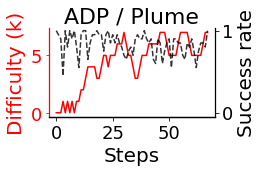

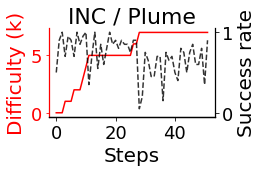

In [5]:
traj = df['runs'].iloc[0][0]
plot_trajectory(traj, title='ADP / Plume', save_path='fig/adp_plume_traj.svg')
plt.show()


traj = df['runs'].iloc[1][0]
plot_trajectory(traj, title='INC / Plume', save_path='fig/inc_plume_traj.svg')
plt.show()

# Plot sample runs

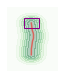

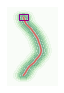

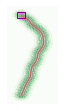

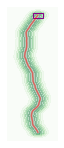

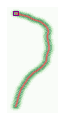

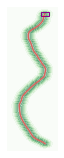

In [6]:
# Sample meander trails
lengths = [10, 30, 50, 70, 90, 100]
all_args = [
    {
        'width': 5,
        'diff_rate': 0.02,
        'radius': 70,
        'reward_dist': -1,
        'range': (-np.pi, np.pi),
        'length': l
    } for l in lengths 
]

for i, args in enumerate(all_args):
    trail_map = MeanderTrail(**args, heading=0)
    trail_map.plot(with_colorbar=False, margin=5, width=1)
    plt.axis('off')
    plt.gcf().tight_layout()
    plt.savefig(f'fig/samp_trail_l={lengths[i]}.svg')
    plt.show()


100%|██████████| 1/1 [00:14<00:00, 14.63s/it]


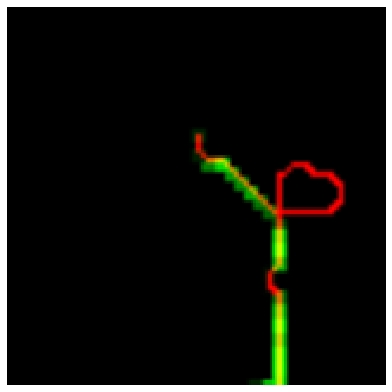

In [7]:
"""Meander trail"""

model_path = data_dir / 'meander_agent.zip'
save_path = Path('trail_examples/tmp')
if not save_path.exists():
    save_path.mkdir()

if not save_path.exists():
    save_path.mkdir()

trail_args = {
    'width': 5,
    'diff_rate': 0.02,
    'radius': 70,
    'reward_dist': -1,
    'range': (-np.pi, np.pi)
}
trail_args['length'] = 500
trail_args['breaks'] = [(0.3, 0.32), (0.5, 0.53), (0.7, 0.72)]

"""Determine how many sample runs you would like"""
n_samps = 1

for i in tqdm(range(n_samps)):
    trail_map = MeanderTrail(**trail_args, heading=0)
    trail_map.max_steps = 1000

    pos_hist, info = run_model(model_path, trail_map)
    plt.clf()
    plot_run(trail_map, pos_hist, save_path=save_path / f'example_{i}.svg')
    plot_observations(i, info['obs'], save_path)

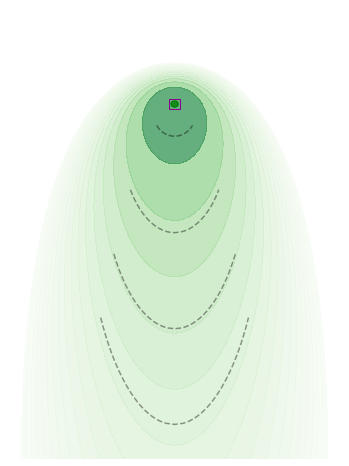

In [8]:
"""Plume trail examples"""
# Sample meander trails
init_rate = 0.5
rate_jump=0.75
rate_spread = 0
n_rates=4

sec_rate = init_rate + n_rates * rate_jump
sec_rate_jump=0.75
n_rates2=4

inv_rates = [init_rate + i * rate_jump for i in range(n_rates)] + [sec_rate + i * sec_rate_jump for i in range(n_rates2)]
srates = [(1 / r) for r in inv_rates][0::2]

all_args = [
    {
        'wind_speed': 5,
        'length_scale': 20,
        'heading': 0,
        'start_rate': s,
        'max_steps': 'auto',
    } for s in srates 
]

trail_map = PlumeTrail(**all_args[-1])
trail_map.plot(x_lim=(-45, 45), y_lim=(-110, 30), with_colorbar=False)

for r in srates:
    y_max, y_min = np.real(trail_map._compute_y(r))
    uppr = y_min * 2/3
    ys = np.linspace(y_min, uppr, num=100)
    dists = np.array([np.real(trail_map._compute_dist(r, y)) for y in ys])
    xs = np.sqrt(dists**2 - ys**2)
    xs = np.concatenate((-np.flip(xs), xs))
    ys = np.concatenate((np.flip(ys), ys))

    plt.plot(xs, ys, 'k--', alpha=0.4)

plt.axis('off')

plt.savefig('fig/plume_starting_pts.svg')
plt.show()

100%|██████████| 1/1 [00:04<00:00,  4.01s/it]


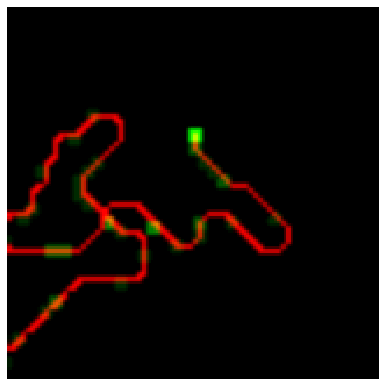

In [9]:
"""Plume trail"""

model_path = data_dir / 'plume_agent.zip'

trail_args = {
    'wind_speed': 5,
    'length_scale': 20,
    'heading': 0,
    'start_rate': 0.25,
    'max_steps': 'auto',
}

n_samps = 1

path = Path(f'plume_examples/tmp')
if not path.exists():
    path.mkdir()

for i in tqdm(range(n_samps)):

    maps = []
    position_hists = []
    odor_hists = []

    trail_map = PlumeTrail(**trail_args)
    _, info = run_model(model_path, trail_map)
    agent = info['agent']

    maps.append(trail_map)
    position_hists.append(np.array(agent.position_history))
    odor_hists.append(agent.odor_history)

    fig, axs = plt.subplots(1, 1, figsize=(6, 12))

    for ax, m, p_hist, odor_hist in zip([axs], maps, position_hists, odor_hists):
        odor_hist = np.array(odor_hist)
        odor_hist = odor_hist[odor_hist[:,0] > 0]

        x_min = min(-30, np.min(p_hist[:,0]))
        x_max = max(30, np.max(p_hist[:,0]))

        y_min = min(-50, np.min(p_hist[:,1]))
        y_max = max(10, np.max(p_hist[:,1]))

        m.plot(ax=ax, x_lim=(x_min-20, x_max+20), y_lim=(y_min - 20, y_max + 20))
        ax.plot(p_hist[:,0], p_hist[:,1], linewidth=1.5, color='black')
        ax.scatter(odor_hist[:,1], odor_hist[:,2], color='darkturquoise', alpha=0.8, s=20)

    ratio = (y_max - y_min + 40) / (x_max - x_min + 40)
    height = 6 * ratio

    fig.set_size_inches((6, height))
    fig.tight_layout()

    plt.axis('off')
    plt.savefig(str(path / f'example_{i}.svg'))
    
    plt.clf()

    plot_observations(i, info['obs'], path)
